In [1]:
import cv2
import glob
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

from random import shuffle
import random

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from tqdm import tqdm
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
#DATA LOADING ...
car_images = glob.glob("/Users/rickerish_nah/Documents/trials/CarND-Vehicle-Detection-master/data/vehicles/*/*.png")
noncar_images = glob.glob("/Users/rickerish_nah/Documents/trials/CarND-Vehicle-Detection-master/data/non-vehicles/*/*.png")
print("#of Car images:",len(car_images))
print("#of Non-Car images:",len(noncar_images))
eg_img = mpimg.imread(car_images[0])
#eg_img = cv2.imread(car_images[0])
#eg_img = cv2.cvtColor(eg_img, cv2.COLOR_BGR2RGB)
shape = eg_img.shape
print("Image shape:",shape)
print("Image data_type:",eg_img.dtype)

#of Car images: 8792
#of Non-Car images: 8968
Image shape: (64, 64, 3)
Image data_type: float32


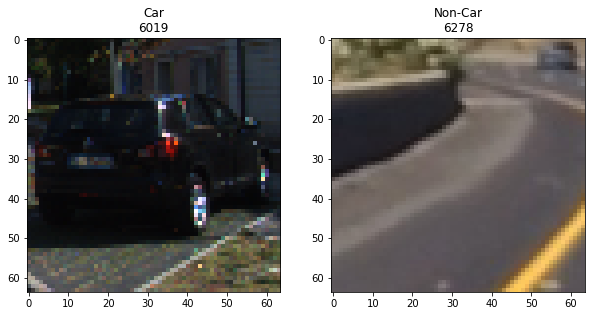

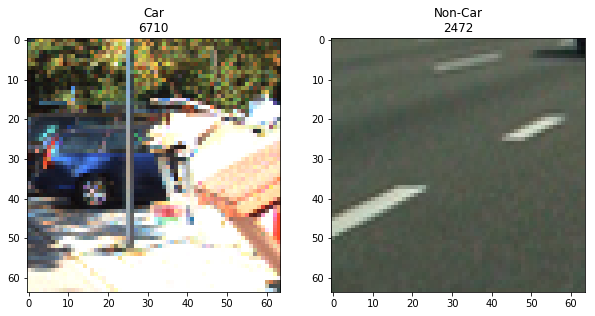

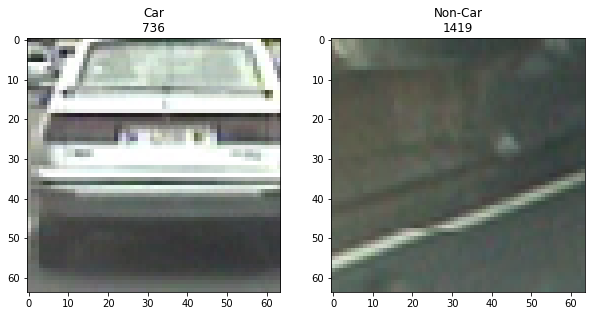

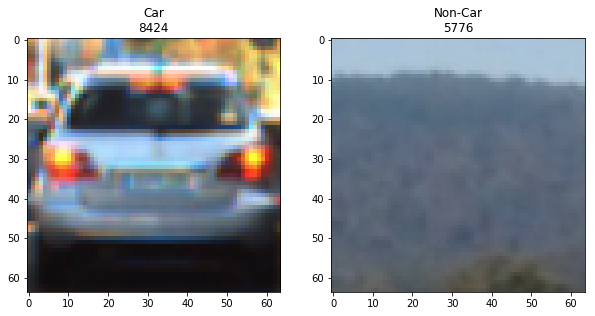

In [3]:
#INPUT DATA VISUALIZATION ...

for i in range(4):
    j_c = random.randint(0,len(car_images))
    img_c = mpimg.imread(car_images[j_c])
    j_nc = random.randint(0,len(noncar_images))
    img_nc = mpimg.imread(noncar_images[j_nc])
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    ax1.imshow(img_c)
    ax1.set_title("Car\n"+str(j_c))
    ax2.imshow(img_nc)
    ax2.set_title("Non-Car\n"+str(j_nc))

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [5]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def vis_bin_spatial(img, color_space='RGB', size=(32, 32)):
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [6]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def vis_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    
    # Generating bin centers
    bin_edges = channel1_hist[1] #all three bins are the same size
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2
    
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist,bin_centers

In [7]:
#Hyperparameters used ...
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
size = (32, 32)
nbins = 32 # number of histogram bins
orient = 15
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' #0,1,2,"ALL"
spatial_feat = True
hist_feat = True
hog_feat = True

Text(0.5,1,'Spatially Binned Features YCbCr')

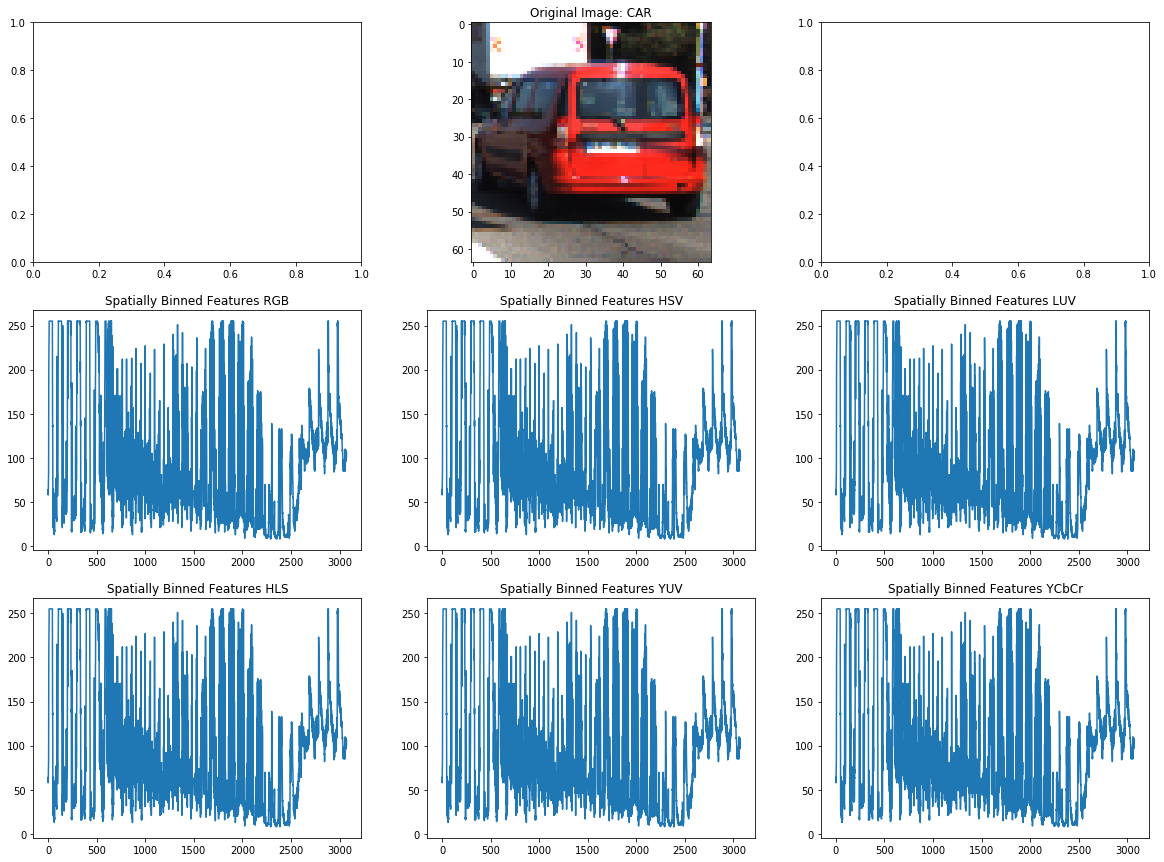

In [8]:
#Visualize Spatial binning of colors...

# Read in the image
img_c = cv2.imread(car_images[3081])
image_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)
img_nc = cv2.imread(noncar_images[2117])
image_nc = cv2.cvtColor(img_nc, cv2.COLOR_BGR2RGB)
f_sb1 = vis_bin_spatial(image_c, color_space='RGB', size=(32, 32))
f_sb2 = vis_bin_spatial(image_c, color_space='HSV', size=(32, 32))
f_sb3 = vis_bin_spatial(image_c, color_space='LUV', size=(32, 32))
f_sb4 = vis_bin_spatial(image_c, color_space='HLS', size=(32, 32))
f_sb5 = vis_bin_spatial(image_c, color_space='YUV', size=(32, 32))
f_sb6 = vis_bin_spatial(image_c, color_space='YCrCb', size=(32, 32))
f, ax = plt.subplots(3,3, figsize=(20,15))
ax[0,1].imshow(image_c)
ax[0,1].set_title("Original Image: CAR")
ax[1,0].plot(f_sb1)
ax[1,0].set_title("Spatially Binned Features RGB")
ax[1,1].plot(f_sb2)
ax[1,1].set_title("Spatially Binned Features HSV")
ax[1,2].plot(f_sb3)
ax[1,2].set_title("Spatially Binned Features LUV")
ax[2,0].plot(f_sb4)
ax[2,0].set_title("Spatially Binned Features HLS")
ax[2,1].plot(f_sb5)
ax[2,1].set_title("Spatially Binned Features YUV")
ax[2,2].plot(f_sb6)
ax[2,2].set_title("Spatially Binned Features YCbCr")

Text(0.5,1,'B Histogram')

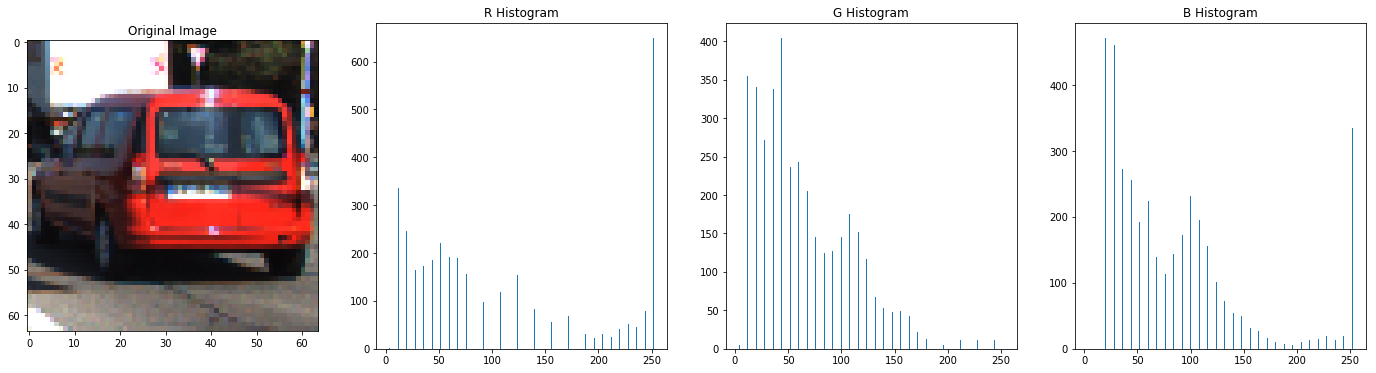

In [9]:
#Visualize Color histogram features...
channel1_hist, channel2_hist, channel3_hist, bin_centers = vis_hist(image_c, nbins=32)
# Plot the examples
f, ax = plt.subplots(1,4, figsize=(24,6))
ax[0].imshow(image_c)
ax[0].set_title("Original Image")
ax[1].bar(bin_centers, channel1_hist[0])
ax[1].set_title("R Histogram")
ax[2].bar(bin_centers, channel2_hist[0])
ax[2].set_title("G Histogram")
ax[3].bar(bin_centers, channel3_hist[0])
ax[3].set_title("B Histogram")

Text(0.5,1,'HOG - B channel')

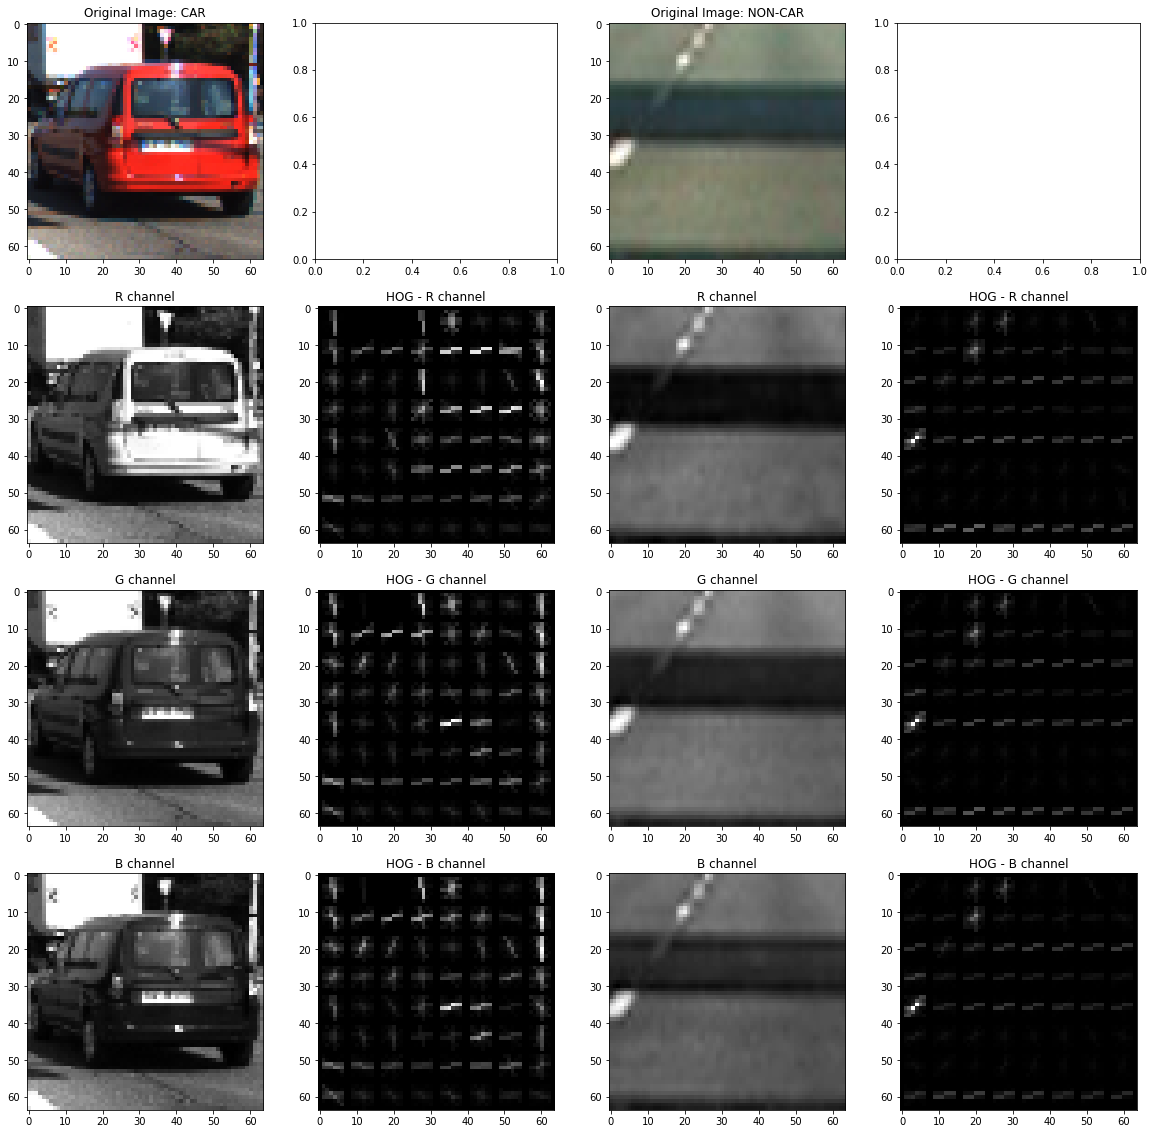

In [10]:
#Visualize HOG features...
#CAR
fc_hog1, ic_hog1 = get_hog_features(image_c[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
fc_hog2, ic_hog2 = get_hog_features(image_c[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
fc_hog3, ic_hog3 = get_hog_features(image_c[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
#NON-CAR
fnc_hog1, inc_hog1 = get_hog_features(image_nc[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
fnc_hog2, inc_hog2 = get_hog_features(image_nc[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
fnc_hog3, inc_hog3 = get_hog_features(image_nc[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

f, ax = plt.subplots(4,4, figsize=(20,20))
#CAR
ax[0,0].imshow(image_c)
ax[0,0].set_title("Original Image: CAR")

ax[1,0].imshow(image_c[:,:,0], cmap = 'gray')
ax[1,0].set_title("R channel")
ax[1,1].imshow(ic_hog1, cmap = 'gray')
ax[1,1].set_title("HOG - R channel")

ax[2,0].imshow(image_c[:,:,1], cmap = 'gray')
ax[2,0].set_title("G channel")
ax[2,1].imshow(ic_hog2, cmap = 'gray')
ax[2,1].set_title("HOG - G channel")

ax[3,0].imshow(image_c[:,:,2], cmap = 'gray')
ax[3,0].set_title("B channel")
ax[3,1].imshow(ic_hog3, cmap = 'gray')
ax[3,1].set_title("HOG - B channel")
#NON-CAR
ax[0,2].imshow(image_nc)
ax[0,2].set_title("Original Image: NON-CAR")

ax[1,2].imshow(image_nc[:,:,0], cmap = 'gray')
ax[1,2].set_title("R channel")
ax[1,3].imshow(inc_hog1, cmap = 'gray')
ax[1,3].set_title("HOG - R channel")

ax[2,2].imshow(image_nc[:,:,1], cmap = 'gray')
ax[2,2].set_title("G channel")
ax[2,3].imshow(inc_hog2, cmap = 'gray')
ax[2,3].set_title("HOG - G channel")

ax[3,2].imshow(image_nc[:,:,2], cmap = 'gray')
ax[3,2].set_title("B channel")
ax[3,3].imshow(inc_hog3, cmap = 'gray')
ax[3,3].set_title("HOG - B channel")


In [11]:
# a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(imgs):
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [12]:
t0=time.time()
car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=size, hist_bins=nbins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(noncar_images, color_space=color_space, 
                        spatial_size=size, hist_bins=nbins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
t1=time.time()
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print("Time taken for feature extraction:",t1-t0)
print('Feature vector length:', len(X_train[0]))

100%|██████████| 8968/8968 [00:55<00:00, 161.74it/s]


Using: 15 orientations 8 pixels per cell and 2 cells per block
Time taken for feature extraction: 179.0527720451355
Feature vector length: 11988


In [13]:
t2=time.time()
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
svc.fit(X_train, y_train)
t3 = time.time()
print(round(t3-t2, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC: {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
print()
t4 = time.time()
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])
t5 = time.time()
print()
print(round(t5-t4, 5), 'seconds to predict 10 labels with SVC.')

40.13 Seconds to train SVC...
Test Accuracy of SVC: 99.04%

  Predictions: [0. 1. 1. 1. 0. 0. 0. 1. 0. 1.]
       Labels: [0. 1. 1. 1. 0. 0. 0. 1. 0. 1.]

0.01859 seconds to predict 10 labels with SVC.


In [14]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [15]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]  # sub-sampling
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #nblocks_per_window = (window // pix_per_cell)-1 

    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
   
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_stacked)    
            #test_features = scaler.transform(np.array(features).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))

    return draw_img, bboxes

In [16]:
def apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bboxes = []
    ystart = 400
    ystop = 500 
    out_img, bboxes1 = find_cars(image, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 500 
    out_img, bboxes2 = find_cars(out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 410
    ystop = 500 
    out_img, bboxes3 = find_cars(out_img, ystart, ystop, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 420
    ystop = 556 
    out_img, bboxes4 = find_cars(out_img, ystart, ystop, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes5 = find_cars (out_img, ystart, ystop, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes6 = find_cars (out_img, ystart, ystop, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 440
    ystop = 556 
    out_img, bboxes7 = find_cars (out_img, ystart, ystop, 1.9, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes8 = find_cars (out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes9 = find_cars (out_img, ystart, ystop, 2.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 500 
    ystop = 656 
    out_img, bboxes10 = find_cars (out_img, ystart, ystop, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes1)
    bboxes.extend(bboxes2)
    bboxes.extend(bboxes3)
    bboxes.extend(bboxes4)
    bboxes.extend(bboxes5)
    bboxes.extend(bboxes6)
    bboxes.extend(bboxes7)
    bboxes.extend(bboxes8)
    bboxes.extend(bboxes9)
    bboxes.extend(bboxes10)
    
    return out_img, bboxes

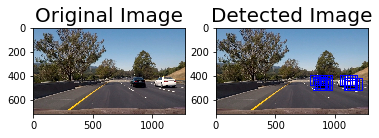

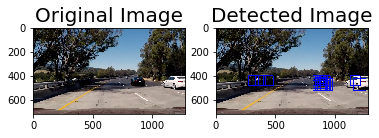

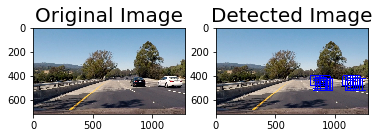

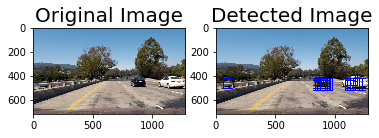

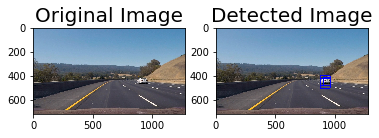

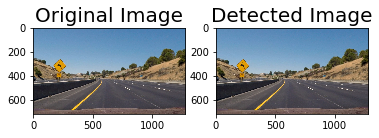

In [17]:
for img in glob.glob('/Users/rickerish_nah/Documents/trials/CarND-Vehicle-Detection-master/test_images/test*.jpg'):
    image = mpimg.imread(img)
    output_image, bboxes = apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, size, nbins)
    f, (ax1,ax2) = plt.subplots(1,2)
    ax1.imshow(image)
    ax1.set_title("Original Image", fontsize=20)
    ax2.imshow(output_image)
    ax2.set_title("Detected Image", fontsize=20)

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [19]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [20]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [21]:
def get_heatmap(bboxes):
    threshold = 1
    heat = np.zeros_like(output_image[:,:,0]).astype(np.float) 
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    return heatmap

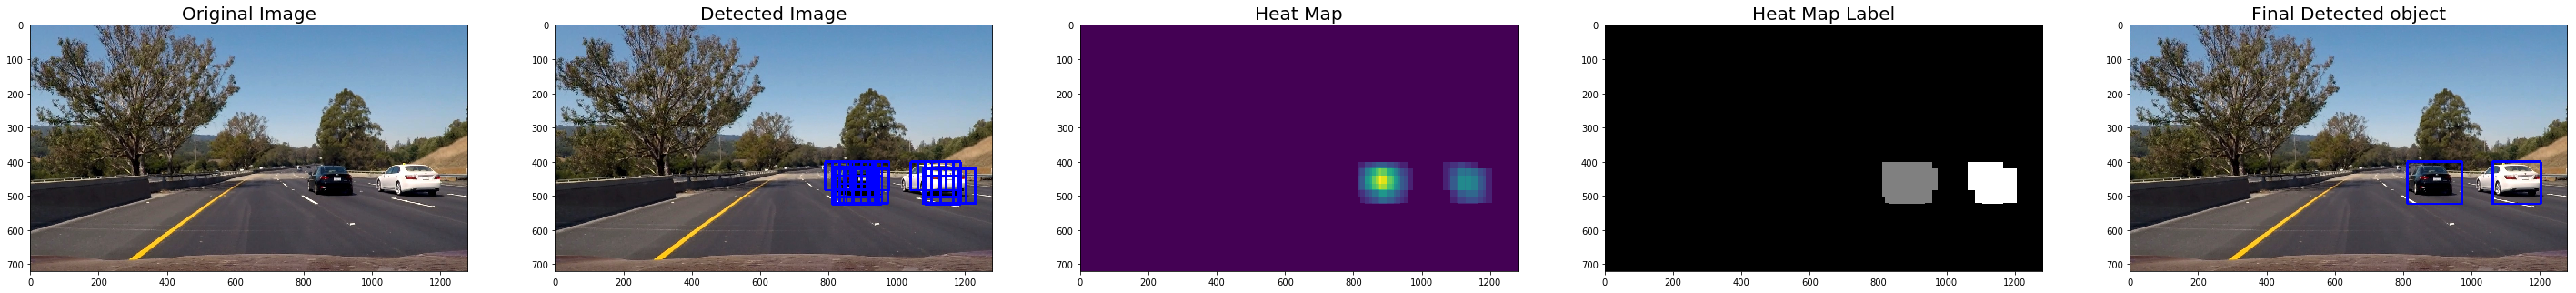

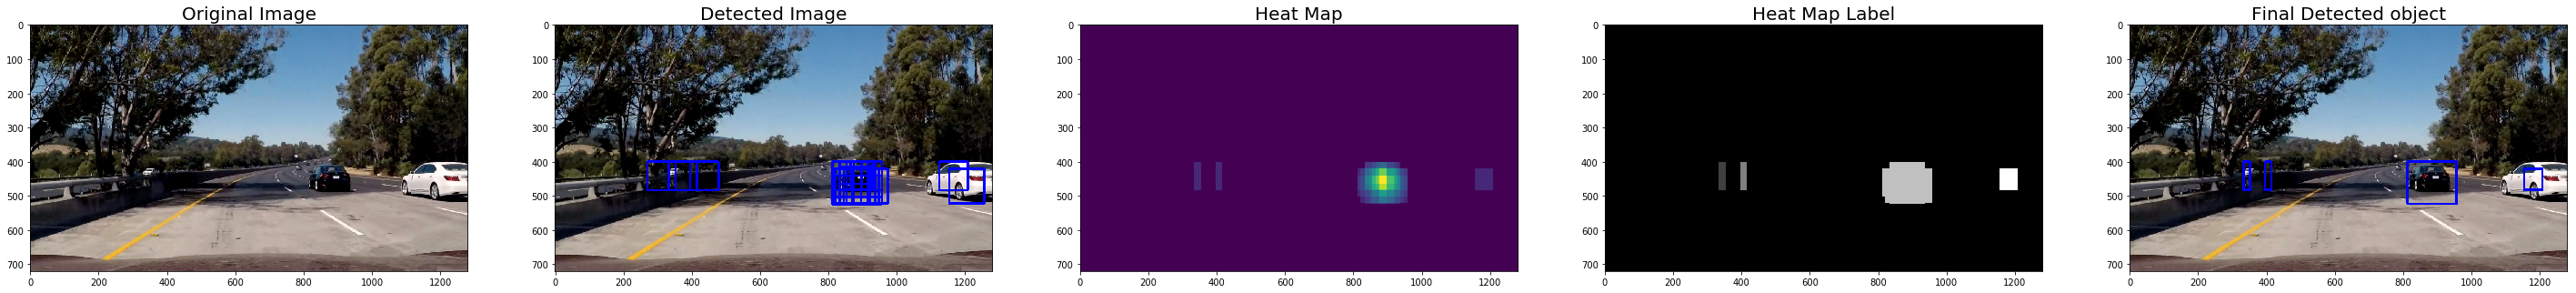

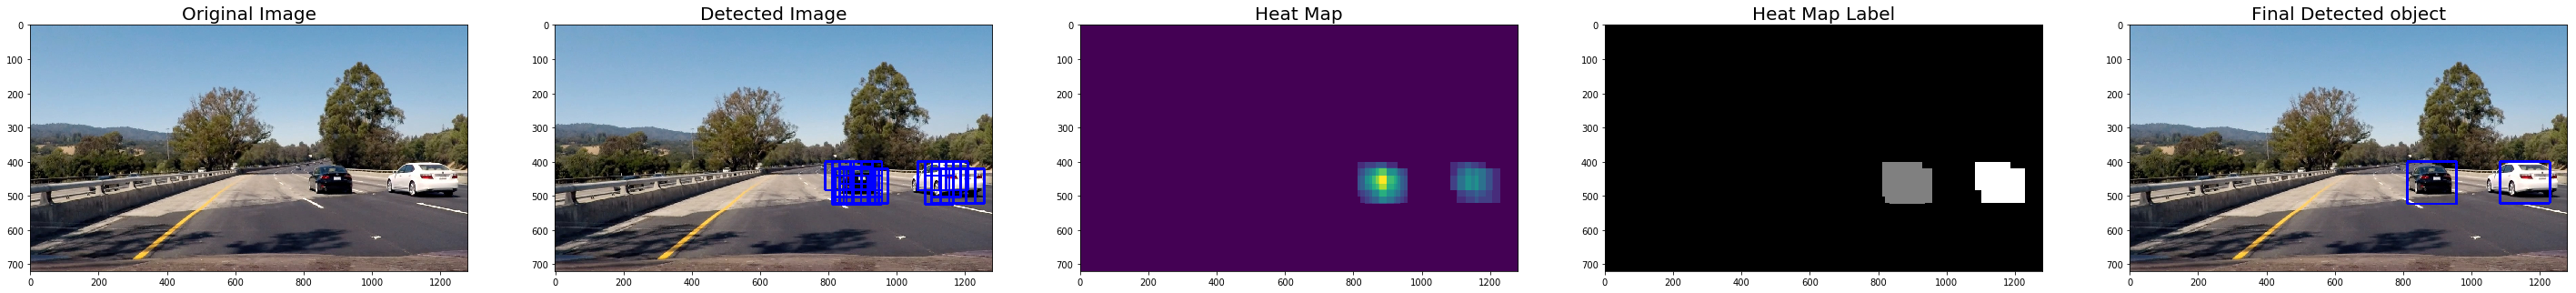

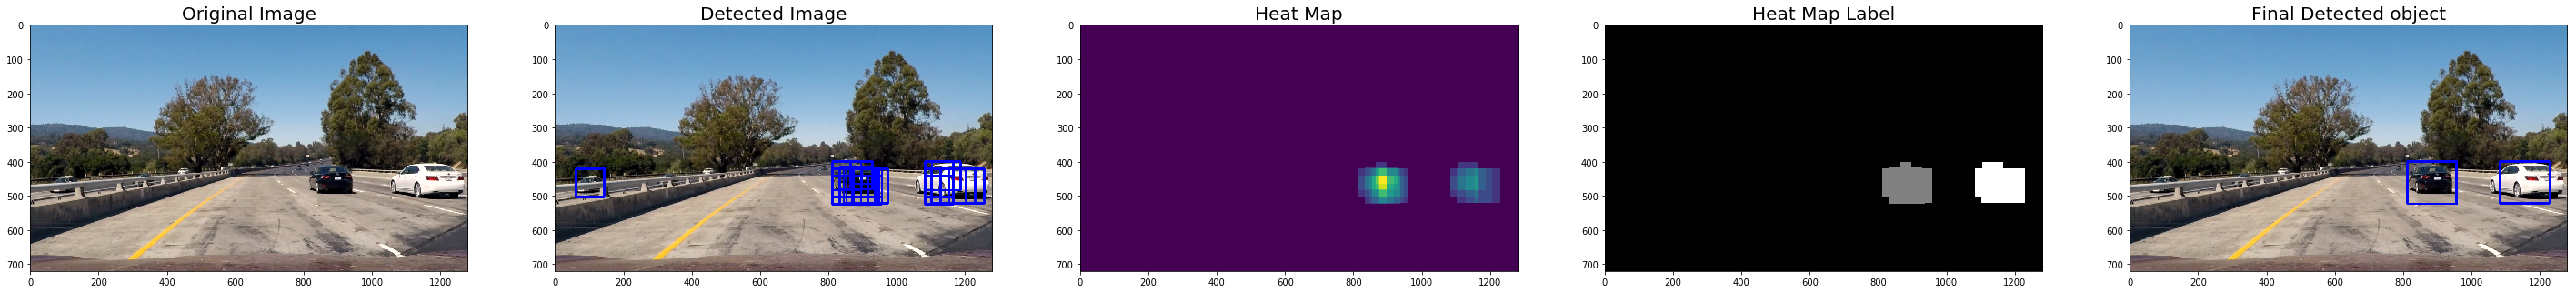

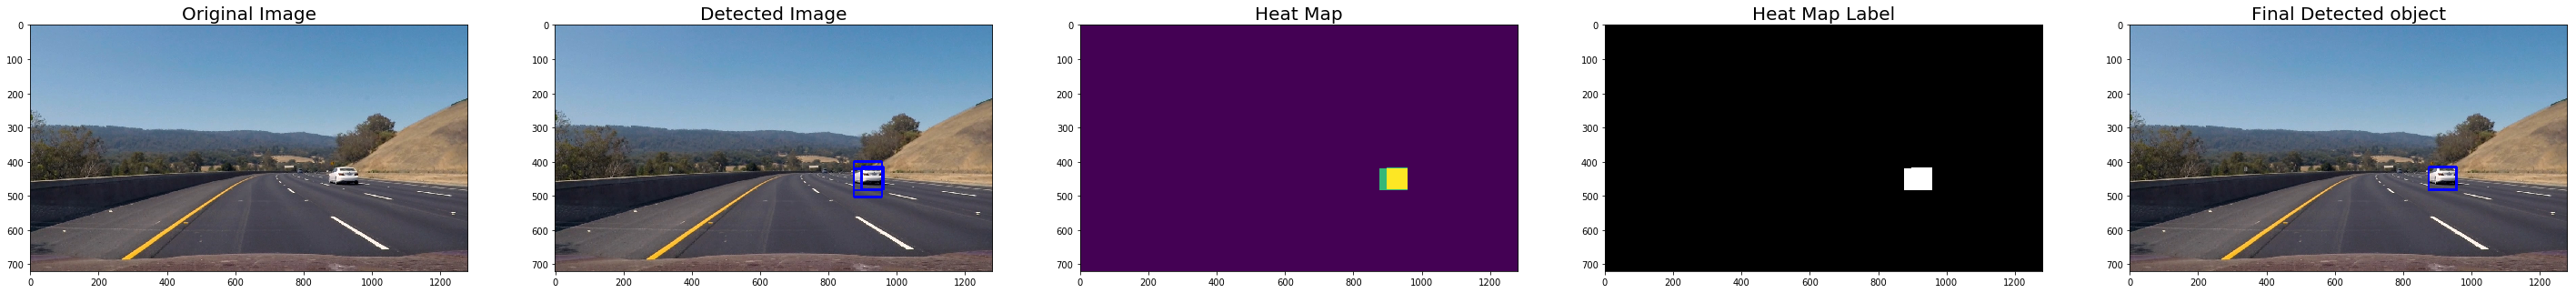

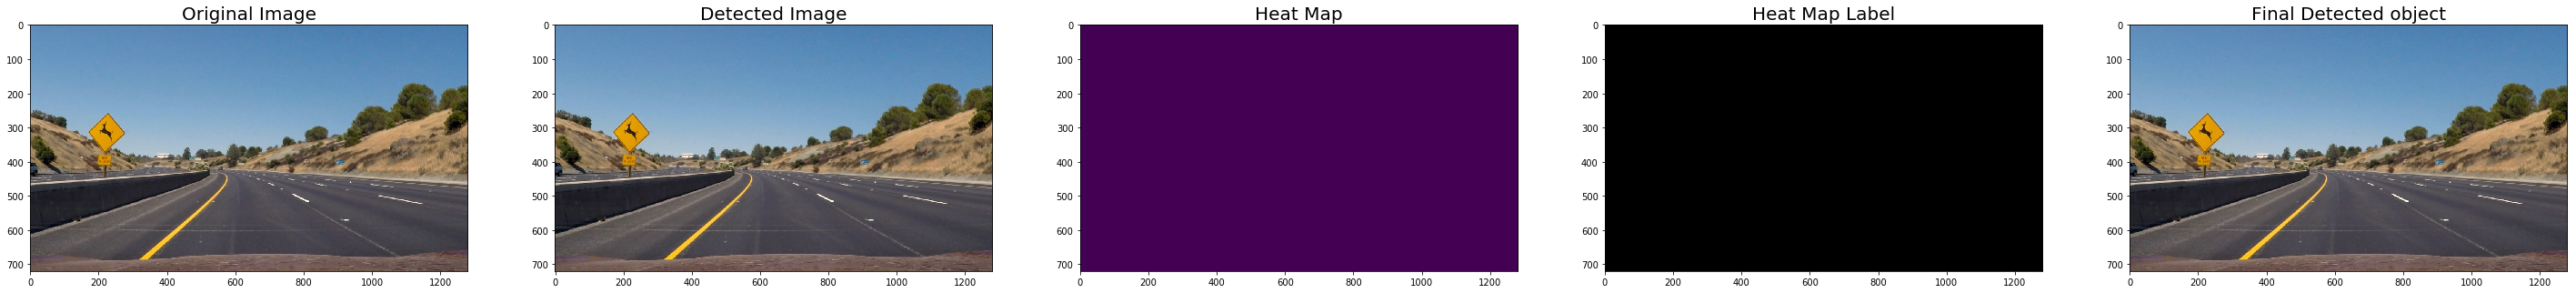

In [22]:
for img in glob.glob('/Users/rickerish_nah/Documents/trials/CarND-Vehicle-Detection-master/test_images/test*.jpg'):
    image = mpimg.imread(img)
    output_image, bboxes = apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, size, nbins)
    heatmap = get_heatmap(bboxes)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(50,30))
    ax1.imshow(image)
    ax1.set_title("Original Image", fontsize=20)
    ax2.imshow(output_image)
    ax2.set_title("Detected Image", fontsize=20)
    ax3.imshow(heatmap)
    ax3.set_title("Heat Map", fontsize=20)
    ax4.imshow(labels[0], cmap='gray')
    ax4.set_title("Heat Map Label", fontsize=20)
    ax5.imshow(draw_img)
    ax5.set_title("Final Detected object", fontsize=20)

In [23]:
def pipeline_detect_car(image):
    #image = mpimg.imread(img)
    output_image, bboxes = apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, size, nbins)
    heatmap = get_heatmap(bboxes)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

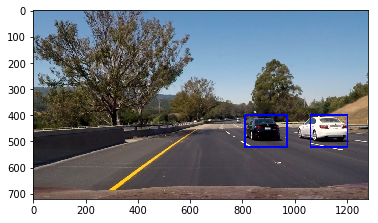

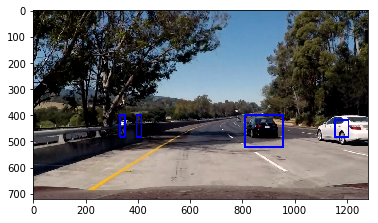

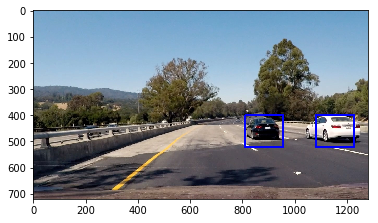

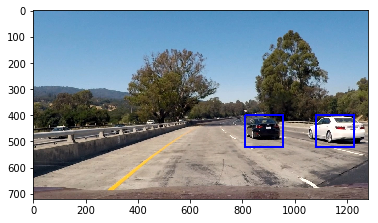

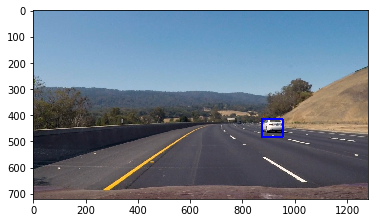

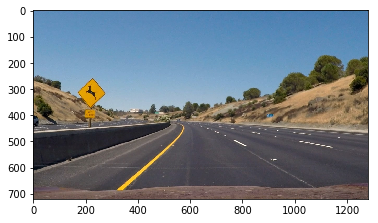

In [24]:
for img in glob.glob('/Users/rickerish_nah/Documents/trials/CarND-Vehicle-Detection-master/test_images/test*.jpg'):
    image = mpimg.imread(img)
    img = pipeline_detect_car(image)
    f, ax = plt.subplots(1,1)
    ax.imshow(img)

In [25]:
white_output = "project_output.mp4"
clip1 = VideoFileClip('/Users/rickerish_nah/Documents/trials/CarND-Vehicle-Detection-master/project_video.mp4')
white_clip = clip1.fl_image(pipeline_detect_car) #NOTE: this function expects color images!!

In [26]:
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [16:26<00:00,  1.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 15min 4s, sys: 59.6 s, total: 16min 4s
Wall time: 16min 27s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))